In [1]:
import yfinance as yf
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import qpsolvers
from scipy.optimize import minimize

In [2]:
stocks_name = "MU SIRI ECA PFE GE GOOG YPF KGC CR ACB USA CHK AMD F X BAC BABA NOK PCG VALE CSCO FLR ANET BBC PXI LIT PXE SNAP RIG GGB CLF GOLD BMY PBR-A WU KHC XOM TEVA ABBV INTC"
stocks_key = set(stocks_name.split( " " ))

In [3]:
data = yf.download( stocks_name , start="2018-04-04", end="2019-04-04")
data.fillna(method='bfill', inplace=True)

[*********************100%***********************]  40 of 40 completed


In [4]:
# Please set parameter of your portofolio
total_value_of_portfolio = 1e6

In [5]:
def return_asset( data , focus_on ):
    return_data = {}
    for key in data[ focus_on ].columns:
        return_data[ key ] = []
        for run in range( 0 , data.shape[0] - 1 ):
            return_data[key].append( data[focus_on][ key ][run + 1 ] / 
                    data[ focus_on ][ key ][ run ] -1 )
    return return_data
                             
class portfolioDataFrame:
    def __init__( self , data , focus_on = "Adj Close"):
        self.data = data
        self.return_data = pd.DataFrame( 
                return_asset( self.data , focus_on ) )
        self.calculate()
        self.prepare_data()
        self.pre_process()
    
    def calculate( self ):
        self.mean_dict = {}
        self.variance_dict = {}
        self.std_dict = {}
        collect_data = []
        for key in self.return_data.columns:
            temp = np.array( self.return_data[ key ].tolist() )
            self.mean_dict[key] = np.mean( temp )
            self.variance_dict[ key ] = np.var( temp )
            self.std_dict[ key ] = np.std( temp )
            collect_data.append( self.return_data[ key ].tolist() )
        self.data_array = np.array( collect_data )
        self.covariance = np.cov( self.data_array , rowvar = True )
        self.correlation = np.corrcoef( self.data_array , rowvar = True )
        
    def prepare_data( self ):
        self.key = {};
        self.list_key = []
        self.mean = []
        self.variance = []
        self.std = []
        run = 0
        for key in self.return_data.columns:
            run+=1
            self.list_key.append( key )
            self.key[ key ] = run
            self.mean.append( self.mean_dict[ key ] )
            self.variance.append( self.variance_dict[ key ] )
            self.std.append( self.std_dict[ key ] )
            
    def pre_process( self ):
        one_array = []
        for key in self.key.keys():
            one_array.append( 1 )
        self.matrix_return = np.array( (
                self.mean,
                one_array
                ) )
        self.matrix_std = np.array((
                self.std,
                one_array
                ))
        self.matrix_var = np.array((
                self.variance,
                one_array
                ))
    

In [6]:
port_stock = "AMD CLF CSCO PFE USA"
#port_stock = "GE INTC NOK T TWTR"
port_key = set( port_stock.split( " " ))
data = yf.download( port_stock , start="2018-04-04", end="2019-04-04" )
data.fillna( method='bfill', inplace=True )

[*********************100%***********************]  5 of 5 completed


In [7]:
port_data = portfolioDataFrame( data )

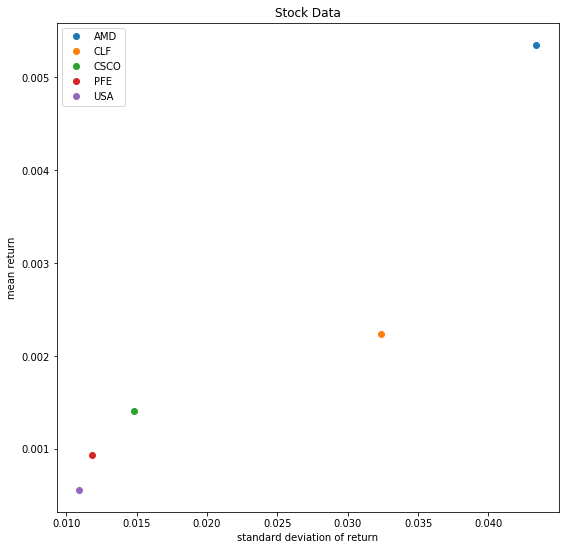

In [8]:
group_data = tuple( port_data.return_data.columns.tolist() )
plt.figure(figsize = ( 9 , 9 ))
for key in group_data:
    plt.plot( port_data.std_dict[key] , port_data.mean_dict[key] , 'o',
            label = key )
#    group_label.append( [key] )
#    x_data.append( port_data.mean[key] )
#    y_data.append( port_data.std[key] )

plt.title('Stock Data')
plt.xlabel( "standard deviation of return")
plt.ylabel( "mean return")
plt.legend()
plt.show()

Above part collect data may be use to calculate perform portfolit optimization.

In [9]:
print( "KEY : " + repr( port_data.key ) )
print( "MEAN: " + repr( port_data.mean ) )
print( "VAR : " + repr( port_data.variance ) )
print( "STD : " + repr( port_data.std ) )

KEY : {'AMD': 1, 'CLF': 2, 'CSCO': 3, 'PFE': 4, 'USA': 5}
MEAN: [0.005351030664471437, 0.0022375910159126537, 0.0014049968294830215, 0.0009330346724378137, 0.0005609734916460417]
VAR : [0.0018814166033585599, 0.0010483554261337073, 0.00021980690486894417, 0.00013926642634621512, 0.00011964758840340047]
STD : [0.04337529946131277, 0.032378317222081, 0.014825886309726788, 0.011801119707308079, 0.010938354007957526]


In [10]:
# Part prepare data
global expect_return, expect_variance , L
list_variance = port_data.variance;
list_return = port_data.mean;
list_std = port_data.std;
list_cov = port_data.covariance;
list_cor = port_data.correlation;
i_bound = ( .0 , 1.0 )
bound = ( i_bound, i_bound, i_bound, i_bound, i_bound)
init = np.full( 5 , 0.2 )
init

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [11]:
list_cov

array([[1.88891229e-03, 5.10779512e-04, 2.80197777e-04, 1.33451115e-04,
        2.36666327e-04],
       [5.10779512e-04, 1.05253214e-03, 1.68926830e-04, 9.48744110e-05,
        1.21153658e-04],
       [2.80197777e-04, 1.68926830e-04, 2.20682630e-04, 9.19937077e-05,
        9.98680545e-05],
       [1.33451115e-04, 9.48744110e-05, 9.19937077e-05, 1.39821273e-04,
        6.24317876e-05],
       [2.36666327e-04, 1.21153658e-04, 9.98680545e-05, 6.24317876e-05,
        1.20124272e-04]])

In [12]:
port_data.return_data.cov()

,AMD,CLF,CSCO,PFE,USA
AMD,0.001889,0.000511,0.000280,0.000133,0.000237
CLF,0.000511,0.001053,0.000169,0.000095,0.000121
CSCO,0.000280,0.000169,0.000221,0.000092,0.000100
PFE,0.000133,0.000095,0.000092,0.000140,0.000062
USA,0.000237,0.000121,0.000100,0.000062,0.000120


In [13]:
def objective_variance( weights ):
    summation = 0
    for run in range( len( weights ) ):
        summation += list_variance[ run ] * weights[ run ]
    return summation
def minus_objective_return( weights ):
    summation = 0
    for run in range( len( weights ) ):
        summation -= weights[ run ] * list_return[run]
    return summation
# This is constrain_return will return about delete expect return  
def constrain_return( weights ):
    global expect_return
    summation = expect_return
    for run in range( len( weights ) ):
        summation -= list_return[ run ] * weights[ run ]
    return summation
# This is constrain_mean will return about expect weights
def constrain_weights( weights ):
    summation = 1
    for run in range( len( weights ) ):
        summation -= weights[ run ]
    return summation
# This is constrain_variance will return about expect variance
def constrain_variance( weights ):
    global expect_variance
    sum_variance = 0
    for i in range( len( weights ) ):
        sum_variance += math.pow( weights[i] , 2 ) * list_variance[ i ]
        for j in range( i , len( weights ) ):
            sum_variance += 2*weights[i]*weights[j]*list_cov[i][j]*list_std[i]*list_std[j]
    return expect_variance - sum_variance

# Return Object
This part will try to use about scipy optimization method SLSQP

In [14]:
def return_objective( expect ):
    global expect_return
    expect_return = expect
    con1 = {'type' : 'eq' , 'fun' : constrain_return  }
    con2 = {'type' : 'eq' , 'fun' : constrain_weights }
    cons = ( con1 , con2 )
    return minimize( objective_variance , init , method='SLSQP' , constraints=cons , bounds=bound )

In [15]:
result = return_objective( 0.003 )

In [16]:
print( "Detail your situation and condition")
print( "inidividual bound weights : " + repr( i_bound ) )
print( "Your expect retrun : " + str( expect_return ) )
print( "Result : ")
if( not result ):
    print( "\tFailure you can't manage your port in this case")
else:
    print( "\tYour risk : " + str( result.fun ) )
    print( "\tYour weights :")
    for run in range( len( result.x ) ):
        print( "\t\t" + port_data.list_key[ run ] + "\t: " + str( result.x[ run ] ) )

Detail your situation and condition
inidividual bound weights : (0.0, 1.0)
Your expect retrun : 0.003
Result : 
	Your risk : 0.0010333445589047322
	Your weights :
		AMD	: 0.3984401815721305
		CLF	: 0.20822798068626058
		CSCO	: 0.15796731834920605
		PFE	: 0.12908756237193153
		USA	: 0.10627695702047145


## Plot efficient frontier

In [17]:
min_value = np.amin( list_return )
max_value = np.amax( list_return )
diff_value = ( max_value - min_value ) / 100.

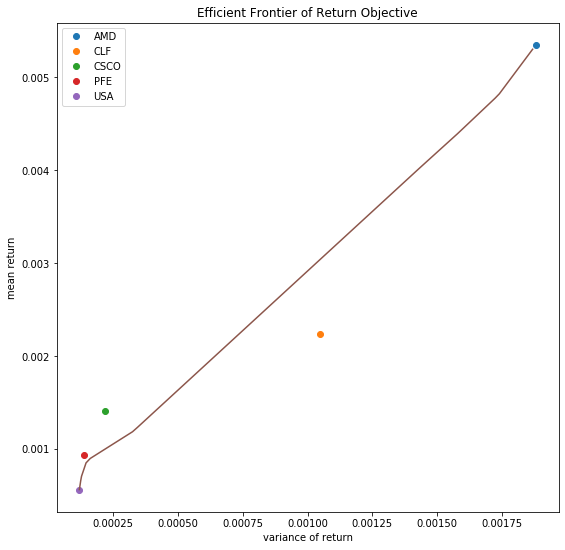

In [18]:
expect_return_return = np.array( [] )
expect_return_risk = np.array( [] )
for target_return in np.arange( min_value , max_value , diff_value ):
    temp_result = return_objective( target_return )
    expect_return_return = np.append( 
            expect_return_return,
            target_return )
    expect_return_risk = np.append(
            expect_return_risk,
            temp_result.fun )
    
plt.figure(figsize = ( 9 , 9 ))
for key in group_data:
    plt.plot( port_data.variance_dict[key] , port_data.mean_dict[key] , 'o',
            label = key )
plt.plot( expect_return_risk , expect_return_return )
plt.title('Efficient Frontier of Return Objective')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.legend()
plt.show()   

# Risk Constraint
max( f(x) ) = - min( -f(x) )

In [19]:
def risk_constraint( expect ):
    global expect_variance
    expect_variance = expect
    con1 = {'type' : 'eq' , 'fun' : constrain_variance }
    con2 = {'type' : 'eq' , 'fun' : constrain_weights }
    cons = ( con1 , con2 )
    return minimize( minus_objective_return , init , method='SLSQP' , constraints=cons , bounds=bound )

In [20]:
result = risk_constraint( 0.0007 )

In [21]:
print( "Detail your situation and condition")
print( "inidividual bound weights : " + repr( i_bound ) )
print( "Your expect variance : " + str( expect_variance ) )
print( "Result : ")
if( not result ):
    print( "\tFailure you can't manage your port in this case")
else:
    print( "\tYour return : " + str( -1.0*result.fun ) )
    print( "\tYour weights :")
    for run in range( len( result.x ) ):
        print( "\t\t" + port_data.list_key[ run ] + "\t: " + str( result.x[ run ] ) )

Detail your situation and condition
inidividual bound weights : (0.0, 1.0)
Your expect variance : 0.0007
Result : 
	Your return : 0.0037322630063385447
	Your weights :
		AMD	: 0.6023416177919214
		CLF	: 0.09670774444389041
		CSCO	: 0.10254674772204286
		PFE	: 0.10037322478516918
		USA	: 0.09803066525697622


## Plot efficient frontier

In [22]:
min_value = np.amin( list_variance )
max_value = np.amax( list_variance )
diff_value = ( max_value - min_value ) / 100

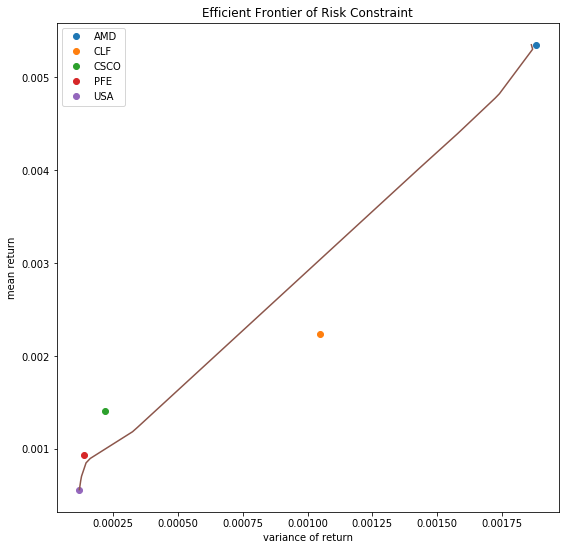

In [23]:
risk_return_return = np.array( [] )
risk_return_risk = np.array( [] )
for target_risk in np.arange( min_value , max_value , diff_value ):
    temp_result = risk_constraint( target_return )
    risk_return_return = np.append( 
            expect_return_return,
            -1.0*temp_result.fun )
    risk_return_risk = np.append(
            expect_return_risk,
            target_risk )
    
plt.figure(figsize = ( 9 , 9 ))
for key in group_data:
    plt.plot( port_data.variance_dict[key] , port_data.mean_dict[key] , 'o',
            label = key )
plt.plot( risk_return_risk , risk_return_return )
plt.title('Efficient Frontier of Risk Constraint')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.legend()
plt.show()   

# Mean-Variance Optimization
max( f(x) ) = -min( -f(x) )

In [24]:
def minus_mean_variance( weights ):
    summation = 0
    global L
    for run in range( len( weights ) ):
        summation -= ( list_return[ run ] - L/2*list_variance[ run ] )*weights[ run ]
    return summation
def report_mean_variance_optimization( result ):
    print( "Report of mean variance optimization")
    for key in result.keys():
        print( "Case" + key + "\t:" )
        print( "\tResult Maximize\t:" + str( result[key].fun ) )
        print( "\tYour weights :")
        for run in range( len( result[key].x ) ):
            print( "\t\t" + port_data.list_key[ run ] + "\t: " + str( result[ key ].x[ run ] ) )

In [25]:
def minus_mean_variance_optimization( L_test ):
    global L
    L = L_test
    con1 = {'type' : 'eq' , 'fun' : constrain_weights }
    cons = ( con1 )
    return minimize( minus_mean_variance , init , method='SLSQP' , constraints=cons , bounds=bound )

In [26]:
test_string = "0.5 1.2 2.3"
test_set = test_string.split(' ')
result_optimization = {}
for test_data in test_set:
    result_optimization[ test_data ] = minus_mean_variance_optimization( float( test_data ) )

In [27]:
report_mean_variance_optimization( result_optimization )

Report of mean variance optimization
Case0.5	:
	Result Maximize	:-0.0048806765136317955
	Your weights :
		AMD	: 0.9999999999999999
		CLF	: 1.1102230246251565e-16
		CSCO	: 7.28583859910259e-17
		PFE	: 0.0
		USA	: 0.0
Case1.2	:
	Result Maximize	:-0.004222180702456298
	Your weights :
		AMD	: 0.9999999999999993
		CLF	: 5.551115123125783e-17
		CSCO	: 9.454242944073599e-17
		PFE	: 1.7694179454963432e-16
		USA	: 3.0531133177191805e-16
Case2.3	:
	Result Maximize	:-0.0031874015706090933
	Your weights :
		AMD	: 1.0
		CLF	: 0.0
		CSCO	: 0.0
		PFE	: 0.0
		USA	: 0.0


In [28]:
min_value = -1
max_value = 1
diff_value = 0.01

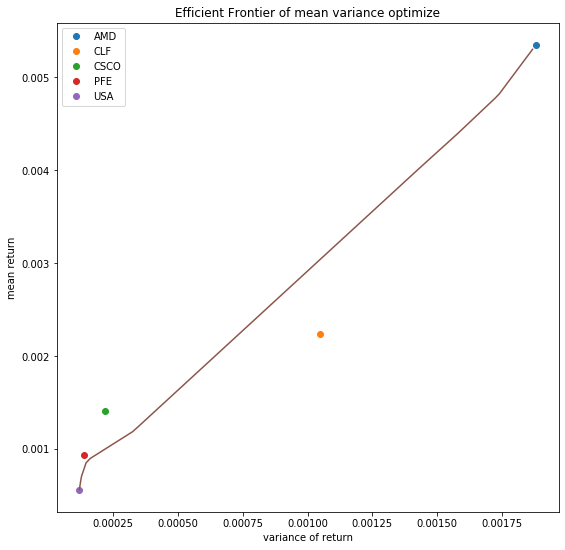

In [29]:
optimize_return = np.array( [] )
optimize_risk = np.array( [] )
for target in np.arange( min_value , max_value , diff_value ):
    temp_result = return_objective( target )
    optimize_return = np.append( 
            optimize_return,
            np.matmul( port_data.matrix_return , result.x )[0] )
    optimize_risk = np.append(
            optimize_risk,
            np.matmul( port_data.matrix_var , result.x )[0] )
    
plt.figure(figsize = ( 9 , 9 ))
for key in group_data:
    plt.plot( port_data.variance_dict[key] , port_data.mean_dict[key] , 'o',
            label = key )
plt.plot( expect_return_risk , expect_return_return )
plt.title('Efficient Frontier of mean variance optimize')
plt.xlabel( "variance of return")
plt.ylabel( "mean return")
plt.legend()
plt.show()   

# Result & Decision

คาดว่าผลที่ได้อาจเป็นเหตุเนื่องจากการเลือกใช้ ฟังก์ชั่น optimization เนื่องจากการใช้ quadratic ได้ลองพยายามใช้แล้ว ไม่สามารถใช้ได้สำเร็จ ติดปัญหาจากการประยุกต์ใช้งาน ไม่สามารถใช้ได้

ผลที่ได้พบว่า ในการ optimization ไม่ว่าจะเลือกทางใด ก็จะได้ผลที่ค่อนข้างใกล้เคียงกัน หมายความการ optimization จะมีจุดๆหนึ่งที่คู่กันเสมอ ไม่ว่าจะเกิดจากการ constrain ในส่วนของ return หรือ risk พบอีกว่า ถ้าคุณกำหนดรูปแบบของการลงทุน short อย่างเดียว หรือ long อย่างเดียว หรือทั้งคู่ จะทำให้ได้กราฟที่มีลักษณะแตกต่างกันออกไป

ในกรณีที่หุ่นที่เราเลือกใช้จัด portfolit มีอัตราส่วนระหว่างความแตกต่างระหว่างผลตอบแทนกับความเสีย่งที่แตกต่างกันมาก มีสิทธิทำให้ weight ที่ใช้มีการ bias ไปฝั่งนั้น เผื่อถ่วงให้คุณมีความเสี่ยงน้อย แสดงว่า หุ้นที่จะเอามาใช้ weight ก็มีผลเช่นกัน 